In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import sys
import imageio
from pathlib import Path
from glob import glob
from scipy.signal import correlate
from tqdm import tqdm
import cv2
from scipy.ndimage import zoom
import os


def vel_field(curr_frame, next_frame, win_size, segment, corr_thresh):
    ys = np.arange(0, curr_frame.shape[0], win_size)
    xs = np.arange(0, curr_frame.shape[1], win_size)
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            seg_win = segment[y : y + win_size, x : x + win_size]
            if np.sum(seg_win) < 5:
                continue
            int_win = curr_frame[y : y + win_size, x : x + win_size]
            search_win = next_frame[y : y + win_size, x : x + win_size]
            cross_corr = correlate(
                search_win - search_win.mean(), int_win - int_win.mean(), method="fft"
            )
            corr_check = cross_corr.max() / np.sum(abs(cross_corr))
            if corr_check > corr_thresh:
                dys[iy, ix], dxs[iy, ix] = (
                    np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
                    - np.array([win_size, win_size])
                    + 1
                )
    # draw velocity vectors from the center of each window
    ys = ys + win_size / 2
    xs = xs + win_size / 2
    return xs, ys, dxs, dys

100%|██████████| 601/601 [00:02<00:00, 220.91it/s]


Text(0.5, 1.0, 'First frame')

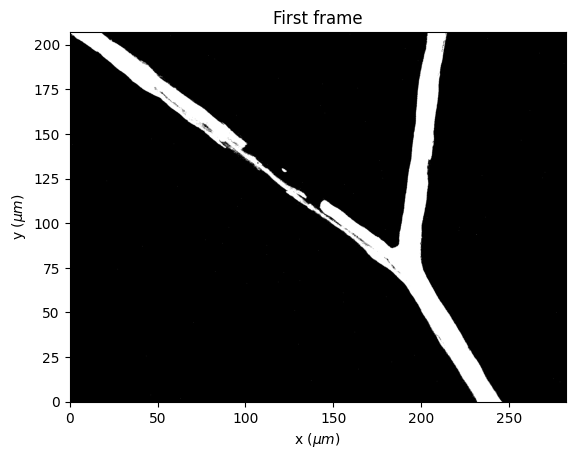

In [26]:
video_address = Path('F:/AMOLF_Data/20221109_Plate462/20221109_Plate462_04/Img/')
pics = [pic for pic in video_address.glob('*.tiff')]

# space_res = .08625
space_res = 2 * 1.725 / 50 * 2
fps = 20
noise_thresh = 60

frame = imageio.v3.imread(pics[0])
frame_res = frame.shape
frame_max = frame.copy()

for pic in tqdm(pics):
    pic_frame = imageio.v3.imread(pic)
    frame_max = np.maximum(frame_max, pic_frame)
vid_dimen = frame.shape

vid_extent = [0, space_res * vid_dimen[1], 0, space_res*vid_dimen[0]]

segment = np.greater(frame_max, noise_thresh)

fag, ax = plt.subplots()
ax.imshow(segment, extent=vid_extent, aspect='auto', cmap='gray', vmin=0)
ax.set_xlabel('x ($\mu m$)')
ax.set_ylabel('y ($\mu m$)')
ax.set_title('First frame')


In [32]:
# a = imageio.imread(pics[0])
# b = imageio.imread(pics[5])

speed_thresh = 10
frame_range = np.arange(0, len(pics), 2)
xss = []
yss = []
dxss= []
dyss= []
norms=[]
oris= []
if not os.path.exists("F:/AMOLF_Data/20221109_Plate462/20221109_Plate462_04/Analysis/PIV/"):
    os.makedirs("F:/AMOLF_Data/20221109_Plate462/20221109_Plate462_04/Analysis/PIV/")


for i, frame_nr in enumerate(tqdm(frame_range)):
    if i == 0:
        continue
    else:
        curr_frame = 1* (cv2.GaussianBlur(imageio.v3.imread(pics[frame_range[i-1]]), (5,5), 0) > noise_thresh)
        next_frame = 1* (cv2.GaussianBlur(imageio.v3.imread(pics[frame_nr]), (5,5), 0) > noise_thresh)
        xs, ys, dxs, dys = vel_field(curr_frame, next_frame, 16, segment*1, 0.001)
        norm_drs = np.sqrt(dxs ** 2 + dys ** 2)
        ori_drs = np.arctan2(dys, dxs)
        
        xss.append(xs)
        yss.append(ys)
        dxss.append(dxs)
        dyss.append(dys)
        norms.append(norm_drs)
        oris.append(ori_drs)
    
        fig, ax = plt.subplots( figsize=(8, 6))
        # we need these flips on y since quiver uses a bottom-left origin, while our
        # arrays use a top-right origin
        ax.quiver(
            xs,
            ys,
            np.where(norm_drs < speed_thresh, dxs, 0),
            np.where(norm_drs < speed_thresh, dys, 0),
            np.where(norm_drs < speed_thresh, norm_drs, 0),
            cmap="plasma",
            angles="xy",
            scale_units="xy",
            scale=0.25,
        )
        ax.imshow(imageio.v3.imread(pics[frame_range[i-1]]))
        fig.savefig(f"F:/AMOLF_Data/20221109_Plate462/20221109_Plate462_04/Analysis/PIV/{i:04}.png")
        plt.close()
        

# xs, ys, dxs, dys = vel_field(a, b, 16, segment*1)


  0%|          | 0/301 [00:00<?, ?it/s]C:\Users\night\AppData\Local\Temp\ipykernel_16552\3878278366.py:30: RuntimeWarning: invalid value encountered in scalar divide
  corr_check = cross_corr.max() / np.sum(abs(cross_corr))
100%|██████████| 301/301 [02:06<00:00,  2.39it/s]


In [36]:
img_address = "F:/AMOLF_Data/20221109_Plate462/20221109_Plate462_04/Analysis/PIV/*.png" 
images = [img_adr for img_adr in glob(img_address)]
frame = cv2.imread(images[0])
height, width, layers = frame.shape

video = cv2.VideoWriter("F:/AMOLF_Data/20221109_Plate462/20221109_Plate462_04/Analysis/PIV_video.mp4", 0, 10, (width,height))
for image in images:
    video.write(cv2.imread(image))

cv2.destroyAllWindows()
video.release()

In [ ]:
norms_adj = np.where(np.array(norms) < 20, norms, 0)
hues = (np.array(oris) + np.pi) / (2*np.pi)
vals = np.array(norms_adj) / np.max(norms_adj)
sats = np.ones(hues.shape)

hsvs = np.array([hues, vals, sats])
hsvs = np.transpose(hsvs, axes=[1,2,3,0])

color_out = np.array(hsv_to_rgb(hsvs) * 256, dtype=np.uint8)
# color_out = zoom(color_out, (1.0, 128, 128, 1))


print(color_out.shape)
# print(np.array(hsv_to_rgb(hsvs) * 256, dtype=np.uint8))

hsvs_mean = hsv_to_rgb(np.max(hsvs, axis=0))

imageio.mimwrite(video_address.joinpath('out.mp4'), 
                 color_out,
                fps=fps,
                quality=4)

fig, ax = plt.subplots(2, figsize=(8, 14))
# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax[1].quiver(
    xs,
    ys,
    np.where(norm_drs < 20, dxs, 0),
    np.where(norm_drs < 20, dys, 0),
    np.where(norm_drs < 20, norm_drs, 0),
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
ax[1].imshow(imageio.v3.imread(pics[-1]))
ax[0].imshow(hsvs_mean)
ax[0].set_aspect("equal")
# ax[1].imshow(np.max(oris, axis=0), cmap='coolwarm', vmin= -np.pi, vmax=np.pi)
plt.show()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (171, 125) to (176, 128) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


(150, 125, 171, 3)


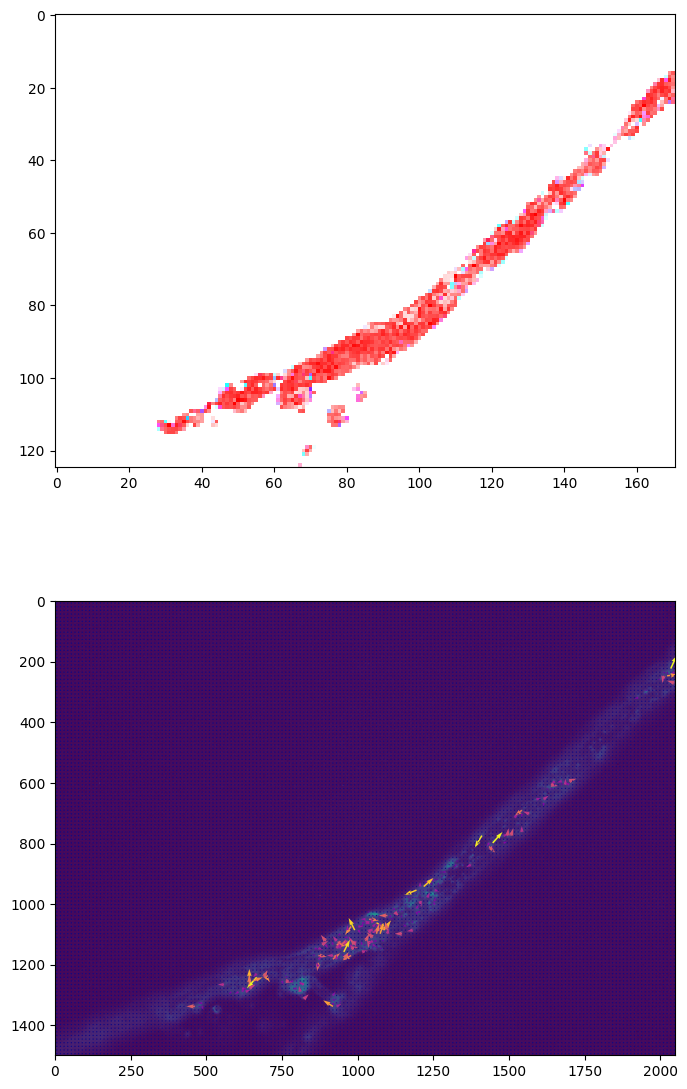

In [16]:
norms_adj = np.where(np.array(norms) < 20, norms, 0)
hues = (np.array(oris) + np.pi) / (2*np.pi)
vals = np.array(norms_adj) / np.max(norms_adj)
sats = np.ones(hues.shape)

hsvs = np.array([hues, vals, sats])
hsvs = np.transpose(hsvs, axes=[1,2,3,0])

color_out = np.array(hsv_to_rgb(hsvs) * 256, dtype=np.uint8)
# color_out = zoom(color_out, (1.0, 128, 128, 1))


print(color_out.shape)
# print(np.array(hsv_to_rgb(hsvs) * 256, dtype=np.uint8))

hsvs_mean = hsv_to_rgb(np.max(hsvs, axis=0))

imageio.mimwrite(video_address.joinpath('out.mp4'), 
                 color_out,
                fps=fps,
                quality=4)

fig, ax = plt.subplots(2, figsize=(8, 14))
# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax[1].quiver(
    xs,
    ys,
    np.where(norm_drs < 20, dxs, 0),
    np.where(norm_drs < 20, dys, 0),
    np.where(norm_drs < 20, norm_drs, 0),
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
ax[1].imshow(imageio.v3.imread(pics[-1]))
ax[0].imshow(hsvs_mean)
ax[0].set_aspect("equal")
# ax[1].imshow(np.max(oris, axis=0), cmap='coolwarm', vmin= -np.pi, vmax=np.pi)
plt.show()